## Логистическая регрессия

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [53]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=100, alpha=0.01, max_epoch=100, penalty='l2'):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = penalty

    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        # Инициализируем начальные веса
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for _ in range(self.max_epoch):
            # Перемешиваем данные
            X, y = self.shuffle(X, y)
            cost = []
            
            for xi, target in zip(X,y):
                output = self.sigmoid(self.net_input(xi))
                errors = (target - output)
                if self.C:
                    if self.penalty == 'l2':
                        self.w_[1:] += self.alpha * (xi.dot(errors) + (1/self.C)*self.w_[:1])
                    elif self.penalty == 'l1':
                        self.w_[1:] += self.alpha * (xi.dot(errors) + (1/self.C)*np.sign(self.w_[:1]))
                        
                else:
                    self.w_[1:] += self.alpha * (xi.dot(errors))
                self.w_[0] += self.alpha * errors.sum()
            
            # Посчитаем функцию потерь по всей выборке по каждой эпохе
            cost = self.loss_function(y, self.sigmoid(self.net_input(X)))
            self.cost_.append(cost)                                               
        return self

    
    def loss_function(self, y, hx):
        
        if self.C:
            if self.penalty == 'l2':
                j = -y.dot(np.log(hx)) - ((1 - y).dot(np.log(1-hx))) + \
                     (1/self.C) * (np.dot(self.w_[1:].T, self.w_[1:]))
            elif self.penalty == 'l1':
                j = -y.dot(np.log(hx)) - ((1 - y).dot(np.log(1-hx))) + \
                     (1/self.C) * (np.abs(self.w_[1:]))
                
        else:
            j = -y.dot(np.log(hx)) - ((1 - y).dot(np.log(1-hx)))
        return j
                          
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        z = self.net_input(X)
        y_hat = np.where(self.sigmoid(z) >= 0.5, 1, 0)
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        z = self.net_input(X)
        
        y_hat_proba = np.column_stack([self.sigmoid(z), 1 - self.sigmoid(z)])
        return y_hat_proba
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))               
        
    def shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

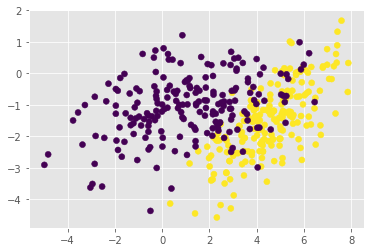

In [54]:
np.random.seed(0)
C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
plt.scatter(X[:,0], X[:,1], c=y)

In [55]:
model = MySGDClassifier()
model.fit(X, y)

MySGDClassifier(C=100, alpha=0.01, max_epoch=100, penalty='l2')

In [56]:
model.w_

array([-7.67342223,  1.47522601, -2.39929934])

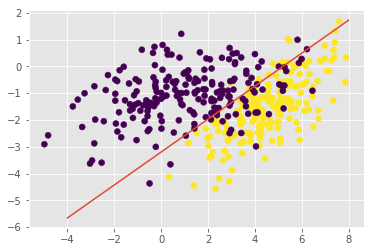

In [57]:
# Нарисуем границу
plt.scatter(X[:,0], X[:,1], c=y)
yi = (-model.w_[0] - (model.w_[1] * np.linspace(-4,8,100))) / model.w_[2]
plt.plot(np.linspace(-4,8,100), yi)

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

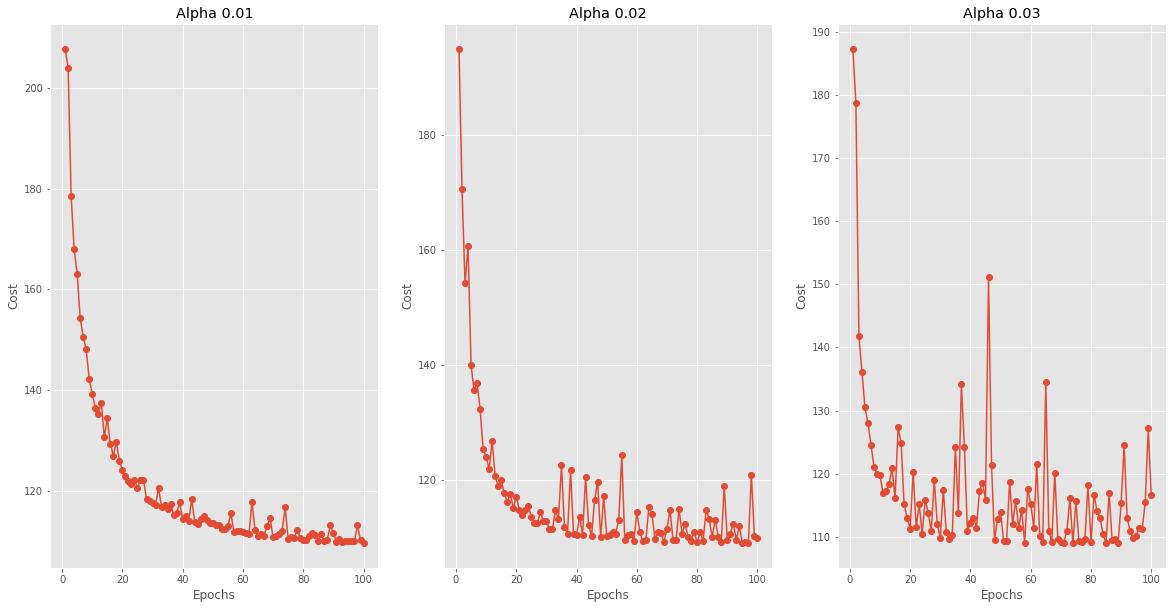

In [60]:
## Your Code Here
alphas = np.linspace(0.01, 0.03, 3)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (20,10))
ax = ax.ravel()
for i, alpha in enumerate(alphas):
    model_ = MySGDClassifier(alpha = alpha, C = 1000, penalty = 'l2')
    model_.fit(X, y)
    ax[i].plot(range(1, len(model_.cost_) + 1), model_.cost_, marker='o')
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Cost')
    ax[i].set_title('Alpha ' + str(np.round(alpha,2)))
plt.subplots_adjust(hspace = 0.6)
